In [69]:
import pandas as pd

import os
import sys
sys.path.append("/Users/antonis/code/Ant-mel/legendary_game_recs/")

import requests
import time
import datetime as datetime

from bs4 import BeautifulSoup

from google.cloud import bigquery

from utils.scraping_and_api_utils import drop_dot_make_int

# Scraping Section

In [3]:
# Setting up the client
client = bigquery.Client.from_service_account_json(os.environ.get('JSON_KEY'))

# Getting the names of the projects and datasets
project = os.environ.get('PROJECT')
dataset = os.environ.get('DATASET')
links_table = os.environ.get('LINKS_TABLE')
game_data_table = os.environ.get('GAME_DATA_TABLE')
missed_data_table = os.environ.get('MISSED_DATA_TABLE')

# Creating the query and running it
query = f"""SELECT * FROM `legendary-game-recs.game_data_01_24.missed_data`"""
query_job = client.query(query)
results = query_job.result()

# Turning our Query into a DF
missed_data = results.to_dataframe()

In [6]:
frame = missed_data.drop_duplicates().copy()
frame.shape

In [8]:
# Setting count for montoring progress
# Only the first 116928 are relevant
count = 0

for game in frame['link']:
    # Monitoring progress
    if count % 10 == True:
        print(count)
    else:
        pass

    count += 1

    try:
        # Setting up the html parser + beautful soup
        game_response = requests.get(f"https://www.backloggd.com{game}")
        game_soup = BeautifulSoup(game_response.content, 'html.parser')


        # Scraping game_id
        game_id = game_soup.find('div', class_='card mx-auto game-cover overlay-hide')['game_id']


        # Scraping the title
        title = game_soup.find('h1', class_='mb-0').string

        # Scraping the date, and making it DateTime
        date_step = game_soup.find('div', class_='col-auto mt-auto pr-0')
        date_step2 = date_step.find('a', href=True).string
        if date_step2 == 'TBD':
            date_as_datetime = datetime.datetime(1, 1, 1).strftime("%Y-%m-%d")

        else:
            date_as_datetime = datetime.datetime.strptime(date_step2, '%b %d, %Y').strftime('%Y-%m-%d')


        # Getting the plays, playing, backlogs and wishlist information

        counter = game_soup.find('div', id='log-counters').find_all('a', class_='plays-counter')

        plays = drop_dot_make_int(counter[0].find('p', class_='mb-0').string.replace('K', '000'))
        playing = drop_dot_make_int(counter[1].find('p', class_='mb-0').string.replace('K', '000'))
        backlogs = drop_dot_make_int(counter[2].find('p', class_='mb-0').string.replace('K', '000'))
        wishlist = drop_dot_make_int(counter[3].find('p', class_='mb-0').string.replace('K', '000'))

        # Get a list of publis
        publisher_list = []
        try:
            publishers = game_soup.find('div', class_='col-auto pl-lg-1 sub-title').find_all('a', href=True)
            for i in range(len(publishers)):
                publisher_list.append(publishers[i].string)
        except:
            publisher_list = []

        # Get Average review score
        review_score = game_soup.find('h1', class_='text-center').string
        if review_score == 'N/A':
            review_score = 0
        else:
            review_score = float(review_score)

        # Get genres
        genres = game_soup.find_all('p', class_='genre-tag')
        genre_list = []
        for i in range(len(genres)):
            genre_list.append(genres[i].string)

        # Get platforms
        platforms = game_soup.find_all('a', class_='game-page-platform')
        platform_list = []
        for i in range(len(platforms)):
            platform_list.append(platforms[i].get_text(strip=True))

        # Get description
        description = game_soup.find('div', id='collapseSummary').get_text(strip=True)

        # Get number of reviews - number of lists associated is here as well
        lists_reviews = game_soup.find_all('p', class_='game-page-sidecard')

        total_lists = drop_dot_make_int(lists_reviews[0].get_text(strip=True).strip(" Lists").replace('K', '000'))
        total_reviews = drop_dot_make_int(lists_reviews[1].get_text(strip=True).strip(" Reviews").replace('K', '000'))

        # Get game category + main (If applicable)
        # If the search for category fails, then the game is the main game
        try:
            main_game = game_soup.find('p', class_='mb-2 game-parent-category').find('a').get_text()
            full_sentence = game_soup.find('p', class_='mb-2 game-parent-category').get_text()
            category = full_sentence.replace(main_game, '').strip()
        except:
            main_game = title
            category = 'main'

        # Get ratings, ten categories from 0.5 to 5.0

        ratings = game_soup.find_all('div', class_="col px-0 top-tooltip")

        ratings_zero_five = int(ratings[0]['data-tippy-content'].split(' |')[0])
        ratings_one_zero = int(ratings[1]['data-tippy-content'].split(' |')[0])
        ratings_one_five = int(ratings[2]['data-tippy-content'].split(' |')[0])
        ratings_two_zero = int(ratings[3]['data-tippy-content'].split(' |')[0])
        ratings_two_five = int(ratings[4]['data-tippy-content'].split(' |')[0])
        ratings_three_zero = int(ratings[5]['data-tippy-content'].split(' |')[0])
        ratings_three_five = int(ratings[6]['data-tippy-content'].split(' |')[0])
        ratings_four_zero = int(ratings[7]['data-tippy-content'].split(' |')[0])
        ratings_four_five = int(ratings[8]['data-tippy-content'].split(' |')[0])
        ratings_five_zero = int(ratings[9]['data-tippy-content'].split(' |')[0])

        # Creating a dictionary to insert into GCP
        data_dict = {'title': title,
                        'release_date': date_as_datetime,
                        'plays':plays,
                        'playing':playing,
                        'backlogs':backlogs,
                        'wishlist':wishlist,
                        'developers':str(publisher_list),
                        'avg_review':review_score,
                        'genres':str(genre_list),
                        'platforms':str(platform_list),
                        'description':description,
                        'total_reviews':total_reviews,
                        'total_lists':total_lists,
                        'category':category,
                        'main':main_game,
                        'ratings_zero_five':ratings_zero_five,
                        'ratings_one_zero':ratings_one_zero,
                        'ratings_one_five':ratings_one_five,
                        'ratings_two_zero':ratings_two_zero,
                        'ratings_two_five':ratings_two_five,
                        'ratings_three_zero':ratings_three_zero,
                        'ratings_three_five':ratings_three_five,
                        'ratings_four_zero':ratings_four_zero,
                        'ratings_four_five':ratings_four_five,
                        'ratings_five_zero':ratings_five_zero,
                        'url':game,
                        'game_id':game_id}

        # Inserting into GCP
        table = client.dataset(dataset).table('game_data_test')
        errors = client.insert_rows_json(table, [data_dict])

        # Relaying errors for some sexy debugging
        if errors:
            print(f'Failed {game}, {errors}')
            #Saving missed data, so we can try get it later
            table = client.dataset(dataset).table('missed_data_2nd')
            errors = client.insert_rows_json(table, [{'link':game}])
        else:
            print(f'all good {count}')


    except:
        # Relaying when Backlogged rejects us
        print(f'Page failure at {game}, count = {count}')
        #Saving missed data, so we can try get it later
        table = client.dataset(dataset).table('missed_data_2nd')
        errors = client.insert_rows_json(table, [{'link':game}])

        time.sleep(3)


all good 1
1
all good 2
all good 3
all good 4
all good 5
all good 6
all good 7
all good 8
all good 9
all good 10
all good 11
11
all good 12
all good 13
all good 14
all good 15
all good 16
all good 17
all good 18
all good 19
all good 20
all good 21
21
all good 22
all good 23
all good 24
all good 25
all good 26
all good 27
all good 28
all good 29
all good 30
all good 31
31
all good 32
all good 33
all good 34
all good 35
all good 36
all good 37
all good 38
all good 39
all good 40
all good 41
41
all good 42
all good 43
all good 44
all good 45
all good 46
all good 47
all good 48
all good 49
all good 50
all good 51
51
all good 52
all good 53
all good 54
all good 55
all good 56
all good 57
all good 58
all good 59
all good 60
all good 61
61
all good 62
all good 63
all good 64
all good 65
all good 66
all good 67
all good 68
all good 69
all good 70
all good 71
71
all good 72
all good 73
all good 74
all good 75
all good 76
all good 77
all good 78
all good 79
all good 80
all good 81
81
all good 82

# API Section

In [2]:
import os
import sys
import pandas as pd
import requests
from igdb.wrapper import IGDBWrapper
import json
sys.path.append("/Users/antonis/code/Ant-mel/legendary_game_recs/")

from google.cloud import bigquery
from google.cloud import secretmanager

from utils.processing_utils import process_raw_data
from utils.scraping_and_api_utils import prepare_json_df

from preprocessing.api_processing import *

import time

In [ ]:
#LEGACY CODE

# query_1 = f"""SELECT * FROM `legendary-game-recs.game_data_01_24.game_data`"""
# query_2 = f"""SELECT * FROM `legendary-game-recs.game_data_01_24.game_data_test`"""

# # query = f"""SELECT * FROM `{project}.{dataset}.{links_table}"""
# query_job_1 = client.query(query_1)
# results_1 = query_job_1.result()
# game_data_1 = results_1.to_dataframe()

# query_job_2 = client.query(query_2)
# results_2 = query_job_2.result()
# game_data_2 = results_2.to_dataframe()

# data = pd.concat([game_data_1, game_data_2]).reset_index(drop=True)

# re, up = process_raw_data(data, 2024, 1, 24)

# all_data = pd.concat([re,up])

In [15]:
# Create a Secret Manager client
secret_client = secretmanager.SecretManagerServiceClient()

# Define the name of the secret
secret_id_name = "projects/legendary-game-recs/secrets/CLIENT_ID/versions/latest"
secret_client_name = "projects/legendary-game-recs/secrets/CLIENT_SECRET/versions/latest"
secret_grant_name = "projects/legendary-game-recs/secrets/GRANT_TYPE/versions/latest"

# # Access the secret
secret_id_response = secret_client.access_secret_version(request={"name": secret_id_name})
secret_client_response = secret_client.access_secret_version(request={"name": secret_client_name})
secret_grant_response = secret_client.access_secret_version(request={"name": secret_grant_name})

# Credentials for calling the API
CLIENT_ID = secret_id_response.payload.data.decode("UTF-8")
CLIENT_SECRET = secret_client_response.payload.data.decode("UTF-8")
GRANT_TYPE = secret_grant_response.payload.data.decode("UTF-8")

In [16]:
# List of games used in the model
client = bigquery.Client.from_service_account_json(os.environ.get('JSON_KEY'))

project = os.environ.get('PROJECT')
dataset = os.environ.get('DATASET')
links_table = os.environ.get('LINKS_TABLE')
game_data_table = os.environ.get('GAME_DATA_TABLE')
missed_data_table = os.environ.get('MISSED_DATA_TABLE')

query = f"""
            SELECT DISTINCT * FROM `legendary-game-recs.game_data_01_24.game_data`
            WHERE release_date != '0001-01-01T00:00:00' AND category = 'main' AND avg_review > 0

            UNION ALL

            SELECT DISTINCT * FROM `legendary-game-recs.game_data_01_24.game_data_test`
            WHERE release_date != '0001-01-01T00:00:00' AND category = 'main' AND avg_review > 0
        """

query_job = client.query(query)
results = query_job.result()
all_data = results.to_dataframe()

list_of_game_id = all_data['game_id']

In [37]:
all_data.shapea1

(36316, 27)

In [35]:
# table_ref = client.dataset('game_data_01_24').table('all_data')
# tabless = client.get_table(table_ref)

# for field in tabless.schema:
#     print(f"{field.name}: {field.field_type},")

In [17]:
#Generating the access token
response = requests.post(f'https://id.twitch.tv/oauth2/token?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&grant_type={GRANT_TYPE}')
response_json = response.json()
ACCESS_TOKEN = response_json['access_token']


#This is a wrapper from IGDB just for their API
wrapper = IGDBWrapper(CLIENT_ID, ACCESS_TOKEN)

no_data = []
list_sons = []
count = 0

for game in list_of_game_id[:15]:
    count += 1

    try:
        the_feat = json.loads(wrapper.api_request('games',
                f'fields franchise, franchises, storyline, aggregated_rating,aggregated_rating_count, game_engines.name, game_modes.name, multiplayer_modes, player_perspectives.name, themes.name, rating; where id = {int(game)};'))
        list_sons.append(the_feat[0])
        print(f'Success at {count}')

    except:
        print(f'failed at {count}')
        no_data.append(game)


Success at 1
Success at 2
Success at 3
Success at 4
Success at 5
Success at 6
Success at 7
Success at 8
Success at 9
Success at 10
Success at 11
Success at 12
Success at 13
Success at 14
Success at 15


In [6]:
missed = pd.DataFrame(no_data, columns=['game_id'])

In [7]:
# # This is used for getting the information from age_ratings.
# def get_category_descriptions(json_dict):
#     category_list = []

#     if type(json_dict) == float:
#         category_list = None
#     else:
#         for i in range(len(json_dict)):
#             try:
#                 descriptions = json_dict[i]['content_descriptions']
#                 for i in range(len(descriptions)):
#                     rating_descript = descriptions[i]['category']
#                     category_list.append(rating_descript)

#             except:
#                 pass

#     return category_list

# # This goes through each key in the JSON and creates a list of items for the variable
# def get_names_from_dict(dict_list):
#     list_of_items = []
#     try:
#         for i in range(len(dict_list)):
#             item = dict_list[i]['name']
#             list_of_items.append(item)
#     except:
#         list_of_items = None

#     return list_of_items

# # This uses the above functions to create a final, clean df
# def prepare_json_df(original_json_df):
#     original_json_df['themes'] = original_json_df['themes'].apply(get_names_from_dict)
#     original_json_df['game_modes'] = original_json_df['game_modes'].apply(get_names_from_dict)
#     original_json_df['player_perspectives'] = original_json_df['player_perspectives'].apply(get_names_from_dict)
#     original_json_df['game_engines'] = original_json_df['game_engines'].apply(get_names_from_dict)
#     # original_json_df['age_ratings'] = original_json_df['age_ratings'].apply(get_category_descriptions)

#     return original_json_df

In [39]:
# Creates a df from the list of dictionaries
new_df = prepare_json_df(pd.DataFrame(list_sons))

In [42]:
everything = all_data.merge(new_df, right_on='id', left_on='game_id', how='right')

In [43]:
everything

,title,release_date,plays,playing,backlogs,wishlist,developers,avg_review,genres,platforms,...,aggregated_rating_count,game_engines,game_modes,player_perspectives,rating,storyline,themes,franchises,multiplayer_modes,franchise
0,Bard's Gold,2015-08-14,14,0,21,1,"['EastAsiaSoft', 'Erdem Sen']",2.0,"['Indie', 'Platform', 'RPG']","['Windows PC', 'Mac', 'Linux', 'PlayStation 4'...",...,3.0,[GameMaker: Studio],[Single player],[Side view],70.000000,"""While I was adventuring, I got my saddle cont...","[Action, Fantasy, Historical]",NaN,NaN,NaN
1,Mario Party 10,2015-03-12,2400,4,146,82,['Nintendo'],2.0,"['Card & Board Game', 'Quiz/Trivia']",['Wii U'],...,16.0,None,"[Single player, Multiplayer, Split screen]",[Third person],61.310368,NaN,"[Action, Party]",[845],[19938],NaN
2,Homefront,2011-03-15,2400,9,404,96,"['Digital Extremes', 'THQ']",2.0,['Shooter'],"['Windows PC', 'Xbox 360', 'PlayStation 3']",...,14.0,[Unreal Engine],"[Single player, Multiplayer]",[First person],68.646107,The year is 2027. The world has suffered a dec...,"[Action, Fantasy, Historical, Warfare]",NaN,NaN,NaN
3,Flappy Bird,2013-05-24,12000,15,97,17,['.GEARS Studios'],2.0,['Arcade'],"['Android', 'iOS']",...,NaN,None,[Single player],[Side view],47.128321,NaN,[Action],NaN,NaN,NaN
4,Saints Row,2022-08-23,1300,105,863,383,"['Volition', 'Deep Silver']",2.0,"['Adventure', 'Shooter']","['Windows PC', 'PlayStation 4', 'Xbox One', 'P...",...,7.0,None,"[Single player, Multiplayer, Co-operative]",[Third person],46.657578,"As the future Boss, with Neenah, Kevin, and El...","[Action, Open world]",NaN,[25622],NaN
5,Finding Nemo,2003-05-09,1300,5,85,33,"[""Traveller's Tales"", 'THQ']",2.0,['Adventure'],"['Nintendo GameCube', 'Xbox', 'PlayStation 2']",...,3.0,None,[Single player],[Third person],60.707378,NaN,"[Action, Educational]",[167],NaN,167.0
6,Realm Royale Reforged,2018-06-05,1200,5,71,3,['Hi-Rez Studios'],2.0,"['Adventure', 'Shooter']","['Windows PC', 'PlayStation 4', 'Xbox One', 'N...",...,2.0,None,"[Single player, Multiplayer, Battle Royale]","[First person, Third person]",60.268947,NaN,"[Action, Fantasy]",NaN,NaN,NaN
7,Fallout 76,2018-11-14,4600,182,1200,256,"['Bethesda Softworks', 'Bethesda Game Studios']",2.0,"['RPG', 'Shooter']","['Windows PC', 'PlayStation 4', 'Xbox One']",...,17.0,[Creation Engine],"[Multiplayer, Co-operative, Massively Multipla...","[First person, Third person]",57.717230,NaN,"[Action, Science fiction, Survival, Open world]",[1034],"[18544, 18545, 18546]",NaN
8,Super Mario Run,2016-12-15,4900,27,117,43,"['Nintendo', 'Nintendo EPD']",2.0,"['Adventure', 'Arcade', 'Platform']","['Android', 'iOS']",...,11.0,[Unity],[Single player],[Side view],67.697619,NaN,"[Action, Kids]",[845],NaN,NaN
9,QWOP,2008-11-01,2900,2,29,19,"['Noodlecake Studios Inc.', 'Bennett Foddy']",2.0,"['Indie', 'Sport']","['Android', 'Mobile', 'Web browser']",...,NaN,None,"[Single player, Multiplayer]",[Side view],74.946860,QWOP is the local sporting hero of a prosperou...,"[Action, Comedy]",NaN,NaN,NaN


In [32]:
# data[data['game_id'].isin(missed['game_id'])].sort_values(by='plays')

In [44]:
# You need to ensure the categorical columns can go in as strings
# Because BiqQuery treats it like a JSON
list_of_lists = ['game_modes', 'franchises', 'franchise', 'player_perspectives', 'themes', 'multiplayer_modes', 'game_engines']
everything[list_of_lists] = everything[list_of_lists].astype(str)

#Uploads to the cloud
job_config = bigquery.LoadJobConfig(write_disposition='WRITE_TRUNCATE')
job = client.load_table_from_dataframe(everything, 'legendary-game-recs.game_data_01_24.all_data', job_config=job_config)

#Uploads to the cloud
job_config = bigquery.LoadJobConfig(write_disposition='WRITE_TRUNCATE')
job = client.load_table_from_dataframe(missed, 'legendary-game-recs.game_data_01_24.missed_api_data', job_config=job_config)


# IGDB and Backlogged Data

In [20]:
from utils.processing_utils import process_raw_data

In [18]:
client = bigquery.Client.from_service_account_json(os.environ.get('JSON_KEY'))

project = os.environ.get('PROJECT')
dataset = os.environ.get('DATASET')
links_table = os.environ.get('LINKS_TABLE')
game_data_table = os.environ.get('GAME_DATA_TABLE')
missed_data_table = os.environ.get('MISSED_DATA_TABLE')

query = f"""
            SELECT DISTINCT * FROM `legendary-game-recs.game_data_01_24.all_data`
        """

query_job = client.query(query)
results = query_job.result()
all_data = results.to_dataframe()


In [19]:
all_data.shape

(35577, 39)

In [22]:
released_games, upcoming_games = process_raw_data(all_data, 2024, 1, 26)

In [26]:
all_games_processed = pd.concat([released_games, upcoming_games])
all_games_processed

,title,release_date,plays,playing,backlogs,wishlist,developers,avg_review,genres,platforms,...,aggregated_rating_count,game_engines,game_modes,player_perspectives,rating,storyline,themes,franchises,multiplayer_modes,franchise
0,Mario Party 10,2015-03-12,2400,4,146,82,[Nintendo],2.0,"[Card & Board Game, Quiz/Trivia]",[Wii U],...,16.0,None,"['Single player', 'Multiplayer', 'Split screen']",['Third person'],61.310368,None,"['Action', 'Party']",[845],[19938],nan
1,Homefront,2011-03-15,2400,9,404,96,"[Digital Extremes, THQ]",2.0,[Shooter],"[Windows PC, Xbox 360, PlayStation 3]",...,14.0,['Unreal Engine'],"['Single player', 'Multiplayer']",['First person'],68.646107,The year is 2027. The world has suffered a dec...,"['Action', 'Fantasy', 'Historical', 'Warfare']",nan,nan,nan
2,Flappy Bird,2013-05-24,12000,15,97,17,[.GEARS Studios],2.0,[Arcade],"[Android, iOS]",...,NaN,None,['Single player'],['Side view'],47.128321,None,['Action'],nan,nan,nan
3,Saints Row,2022-08-23,1300,105,863,383,"[Volition, Deep Silver]",2.0,"[Adventure, Shooter]","[Windows PC, PlayStation 4, Xbox One, PlayStat...",...,7.0,None,"['Single player', 'Multiplayer', 'Co-operative']",['Third person'],46.657578,"As the future Boss, with Neenah, Kevin, and El...","['Action', 'Open world']",nan,[25622],nan
4,Finding Nemo,2003-05-09,1300,5,85,33,"[Travellers Tales"", THQ]",2.0,[Adventure],"[Nintendo GameCube, Xbox, PlayStation 2]",...,3.0,None,['Single player'],['Third person'],60.707378,None,"['Action', 'Educational']",[167],nan,167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18403,Die in the Dungeon,2024-06-01,20,2,13,25,[DitD Team],3.3,"[Card & Board Game, Indie, RPG, Strategy]","[Windows PC, Mac, Linux]",...,NaN,['Unity'],['Single player'],['Side view'],NaN,"Each dice represents a different action, from ...",['Fantasy'],nan,nan,nan
22290,Darling Duality: Winter Wish,2024-12-31,11,0,2,3,[Melancholy Marionette],2.2,[Visual Novel],"[Windows PC, Mac, Linux]",...,NaN,['Unity'],['Single player'],['Text'],NaN,Sinister or sweet? Pick your poison...\n\nOn o...,['Romance'],nan,nan,nan
28657,Enigma of Fear,2024-03-31,19,0,36,210,"[Nuuvem, Dumativa Game Studio]",2.1,"[Adventure, Indie, Puzzle]",[Windows PC],...,NaN,['Unity'],['Single player'],['Bird view / Isometric'],NaN,Explore the Perimeter in any way you like with...,"['Action', 'Horror', 'Survival']",nan,nan,nan
33266,Selaco,2024-05-30,29,2,80,206,[],3.6,"[Adventure, Shooter]","[Windows PC, Linux]",...,NaN,['GZDoom'],None,['First person'],NaN,None,['Action'],nan,nan,nan


In [27]:
all_data.columns

Index(['title', 'release_date', 'plays', 'playing', 'backlogs', 'wishlist',
       'developers', 'avg_review', 'genres', 'platforms', 'description',
       'total_reviews', 'total_lists', 'category', 'main', 'ratings_zero_five',
       'ratings_one_zero', 'ratings_one_five', 'ratings_two_zero',
       'ratings_two_five', 'ratings_three_zero', 'ratings_three_five',
       'ratings_four_zero', 'ratings_four_five', 'ratings_five_zero', 'url',
       'game_id', 'id', 'aggregated_rating', 'aggregated_rating_count',
       'game_engines', 'game_modes', 'player_perspectives', 'rating',
       'storyline', 'themes', 'franchises', 'multiplayer_modes', 'franchise'],
      dtype='object')

In [30]:
cols_to_remove = ['title', 'release_date', 'plays', 'playing', 'backlogs', 'wishlist',
       'developers', 'avg_review', 'genres', 'platforms', 'description',
       'total_reviews', 'total_lists', 'category', 'main', 'ratings_zero_five',
       'ratings_one_zero', 'ratings_one_five', 'ratings_two_zero',
       'ratings_two_five', 'ratings_three_zero', 'ratings_three_five',
       'ratings_four_zero', 'ratings_four_five', 'ratings_five_zero', 'url',
       'game_id', 'id', 'aggregated_rating', 'aggregated_rating_count',
       'game_engines', 'game_modes', 'player_perspectives', 'rating',
       'storyline', 'themes', 'franchises', 'multiplayer_modes', 'franchise']

cols_to_keep = ['avg_review', 'genres', 'platforms', 'description',
       'total_lists','game_engines', 'game_modes', 'player_perspectives', 'themes','multiplayer_modes']

num_cols_to_keep = ['avg_review', 'total_lists']

cat_cols_to_keep = ['genres', 'game_modes', 'player_perspectives', 'themes']

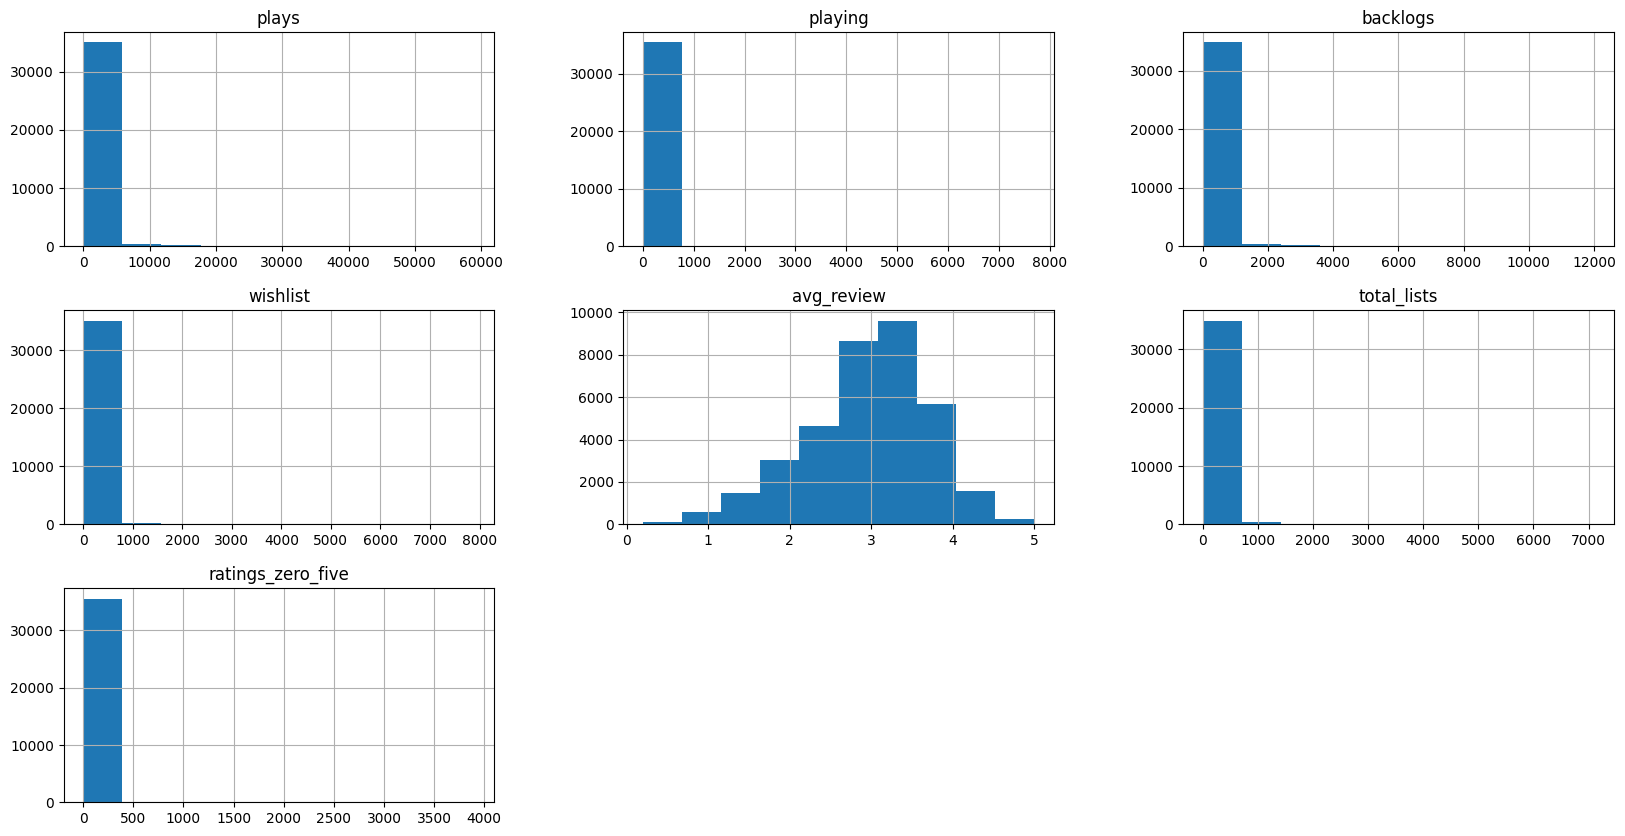

In [34]:
all_data[num_cols_to_keep].hist(figsize=(20,10));

In [38]:
all_data[cat_cols_to_keep].nunique()

developers             18606
genres                  1952
platforms               2338
description            34624
game_engines             815
game_modes                44
player_perspectives       69
themes                  1285
multiplayer_modes       4130
dtype: int64